In [ ]:
!sudo apt-get update
!pip install tf-agents-nightly
!pip install tf-nightly

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubun

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.environments import py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.policies import random_tf_policy
tf.compat.v1.enable_v2_behavior()

# Elevator system model

In [ ]:
#-----------------------------------------------------
class Floor:
  def __init__(self, prob):
    self.called = False
    self.prob = prob #probability of elevator being called to this floor
    self.passArray = []

#-----------------------------------------------------
class Elevator:
  def __init__(self):
    self.pos = 0 #elevator position
    self.passArray = [] #array of passengers (max 4)

#-----------------------------------------------------
class Passenger:
  def __init__(self):
    self.time = 0
    #passenger stress tracking
    self.stops = 0
    self.stress = 0

#-----------------------------------------------------
class ElevatorSystem:
  def __init__(self, seed=None):
    self.floors = [Floor(0.6875), Floor(0.75), Floor(0.84375), Floor(0.9375), Floor(1)]
    self.elv = Elevator() 
    random.seed(seed)#seed to keep training consistent
    #system stress tracking
    self.stress = 0
    self.preStress = 0
    self.passengers = 0
    self.totalPassengers = 0

  #------------------------------
  def event(self): #check if any floor is called
    e = random.random()
    for i in range(len(self.floors)):
      if e < self.floors[i].prob:
        if i == 0:
          return
        else:
          self.callFloor(i)
          return

  #------------------------------
  def callFloor(self, i):
    self.floors[i].called = True
    self.floors[i].passArray.append(Passenger()) #create new passenger
    self.passengers += 1
    self.totalPassengers += 1

  #------------------------------
  def openElv(self):
    if self.elv.pos == 0:
      self.passengers -= len(self.elv.passArray)
      self.elv.passArray = [] #passengers exit elevator
    else:
      while self.floors[self.elv.pos].called and len(self.elv.passArray) < 4: #if passenger is waiting at this floor
        self.elv.passArray.append(self.floors[self.elv.pos].passArray.pop(0)) #move passengers into elevator
        if len(self.floors[self.elv.pos].passArray) == 0:
          self.floors[self.elv.pos].called = False
  
  #------------------------------
  def calcStress(self, action):
    for floor in self.floors:
      for passenger in floor.passArray:
        passenger.time += 1
        #stress stuff
        s = 6.1
        passenger.stress += s
        self.stress += s
    for passenger in self.elv.passArray:
      passenger.time += 1
      #stress stuff
      if action == 1:
        s = (28 * (2.12 ** passenger.stops)) - (28 * (2.12 ** (passenger.stops - 1)))
        if s > 300:
          s = 300
        passenger.stops += 1
        passenger.stress += s
        self.stress += s
      if action == 2:
        s = 830
        passenger.stress += s
        self.stress += s

  #------------------------------
  def runInterval(self, action):
    self.preStress = self.stress
    self.event()

    if action == 0: #move down 1 floor
      if self.elv.pos == 0: #if already on ground floor dont move
        action = 1
      else:
        self.elv.pos -= 1

    elif action == 2: #move up 1 floor
      if self.elv.pos == 4: #if already on top floor dont move
        action = 1
      else:
        self.elv.pos +=1

    if action == 1: #stay on current floor
      self.openElv()

    self.calcStress(action)

# RL enviroments

In [ ]:
environmentSeed = 77759564327

def getStateArray(elevator):
  state = [[],[],[],[],[],[],[],[]]
  for i in range(4):
    if elevator.floors[i+1].called:
      state[i] = [i+1,len(elevator.floors[i+1].passArray),elevator.floors[i+1].passArray[0].time,elevator.floors[i+1].passArray[0].stops]
    else:
      state[i] = [i+1,0,0,0]
  for i in range(4,8):
    if i - 4 < len(elevator.elv.passArray):
      state[i] = [elevator.elv.pos,1,elevator.elv.passArray[i - 4].time,elevator.elv.passArray[i - 4].stops]
    else:
      state[i] = [elevator.elv.pos,0,0,0]
  return state

def programmedPolicy(elevator):
  #the lift does not move
  action = 1
  #if the lift is empty and there are people waiting at a floor below its position and the current floor has not been called it moves down
  if len(elevator.elv.passArray) == 0 and elevator.floors[elevator.elv.pos].called == False:
    for i in range(elevator.elv.pos - 1,0,-1):
      if i > 0:
        if elevator.floors[i].called:
          action = 0
  #if the lift is empty and there are people wating at a floor above its position it moves up
  if len(elevator.elv.passArray) == 0:
    for i in range(elevator.elv.pos + 1,5):
      if elevator.floors[i].called:
        action = 2
  #if the lift has passengers and if either the current floor has not been called or the lift is full it moves down
  if len(elevator.elv.passArray) > 0:
    if elevator.floors[elevator.elv.pos].called == False or len(elevator.elv.passArray) == 4:
      action = 0
  return action

In [ ]:
class MinStressEnv(py_environment.PyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(shape=(8,4), dtype=np.int32, name='observation')
    self.elevator = ElevatorSystem(environmentSeed)
    self._state = [
                   [1,0,0,0],
                   [2,0,0,0],
                   [3,0,0,0],
                   [4,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]
    ]
    self.s = 0
    self.stuck = 0
    self._episode_ended = False


  #------------------------------
  def action_spec(self):
    return self._action_spec

  #------------------------------
  def observation_spec(self):
    return self._observation_spec

  #------------------------------
  def _reset(self):
    self.elevator = ElevatorSystem(environmentSeed)
    self._state = [
                   [1,0,0,0],
                   [2,0,0,0],
                   [3,0,0,0],
                   [4,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]
    ]
    self.s = 0
    self.stuck = 0
    self._episode_ended = False
    return ts.restart(np.array(self._state, dtype=np.int32))

  #------------------------------
  def _step(self, action):
    if self._episode_ended:
      return self.reset()
    self.elevator.runInterval(action)
    #calculate state array
    self._state = getStateArray(self.elevator)
    #calculate reward
    reward = -(self.elevator.stress - self.elevator.preStress)

    #add negative reward if the elevator is stuck
    if len(self.elevator.elv.passArray) == 0:
      self.stuck += 1
    else:
      self.stuck = 0

    if self.stuck > 10:
      reward -= 1500
    

    if self.s == 50:
      self._episode_ended = True
      return ts.termination(np.array(self._state, dtype=np.int32), reward)
    else:
      self.s += 1
      return ts.transition(np.array(self._state, dtype=np.int32), reward, discount=0.9)

In [ ]:
class ProgPolicyEnv(py_environment.PyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(shape=(8,4), dtype=np.int32, name='observation')
    self.elevator = ElevatorSystem()
    self._state = [
                   [1,0,0,0],
                   [2,0,0,0],
                   [3,0,0,0],
                   [4,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]
    ]
    self.s = 0
    self._episode_ended = False


  #------------------------------
  def action_spec(self):
    return self._action_spec

  #------------------------------
  def observation_spec(self):
    return self._observation_spec

  #------------------------------
  def _reset(self):
    self.elevator = ElevatorSystem()
    self._state = [
                   [1,0,0,0],
                   [2,0,0,0],
                   [3,0,0,0],
                   [4,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]
    ]
    self.s = 0
    self._episode_ended = False
    return ts.restart(np.array(self._state, dtype=np.int32))

  #------------------------------
  def _step(self, action):
    if self._episode_ended:
      return self.reset()
    #calculate reward
    reward = 0
    progAction = programmedPolicy(self.elevator)
    if progAction == action:
      reward = 1
    self.elevator.runInterval(progAction)
    #calculate state array
    self._state = getStateArray(self.elevator)

    if self.s == 50:
      self._episode_ended = True
      return ts.termination(np.array(self._state, dtype=np.int32),reward)
    else:
      self.s += 1
      return ts.transition(np.array(self._state, dtype=np.int32),reward,discount=0.0)

In [ ]:
class MinTimeEnv(py_environment.PyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(shape=(8,4), dtype=np.int32, name='observation')
    self.elevator = ElevatorSystem(environmentSeed)
    self._state = [
                   [1,0,0,0],
                   [2,0,0,0],
                   [3,0,0,0],
                   [4,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]
    ]
    self.s = 0
    self._episode_ended = False

  #------------------------------
  def action_spec(self):
    return self._action_spec

  #------------------------------
  def observation_spec(self):
    return self._observation_spec

  #------------------------------
  def _reset(self):
    self.elevator = ElevatorSystem(environmentSeed)
    self._state = [
                   [1,0,0,0],
                   [2,0,0,0],
                   [3,0,0,0],
                   [4,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]
    ]
    self.s = 0
    self._episode_ended = False
    return ts.restart(np.array(self._state, dtype=np.int32))

  #------------------------------
  def _step(self, action):
    if self._episode_ended:
      return self.reset()
    self.elevator.runInterval(action)
    #calculate state array
    self._state = getStateArray(self.elevator)
    #calculate reward
    reward = -self.elevator.passengers

    if self.s == 50:
      self._episode_ended = True
      return ts.termination(np.array(self._state, dtype=np.int32),reward)
    else:
      self.s += 1
      return ts.transition(np.array(self._state, dtype=np.int32),reward,discount=1.0)

In [ ]:
class EvalStressEnv(py_environment.PyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(shape=(8,4), dtype=np.int32, name='observation')
    self.elevator = ElevatorSystem()
    self._state = [
                   [1,0,0,0],
                   [2,0,0,0],
                   [3,0,0,0],
                   [4,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]
    ]
    self.s = 0
    self.stress =0
    self._episode_ended = False

  #------------------------------
  def action_spec(self):
    return self._action_spec

  #------------------------------
  def observation_spec(self):
    return self._observation_spec

  #------------------------------
  def _reset(self):
    self.elevator = ElevatorSystem()
    self._state = [
                   [1,0,0,0],
                   [2,0,0,0],
                   [3,0,0,0],
                   [4,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]
    ]
    self.s = 0
    self.stress =0
    self._episode_ended = False
    return ts.restart(np.array(self._state, dtype=np.int32))

  #------------------------------
  def _step(self, action):
    if self._episode_ended:
      return self.reset()
    self.elevator.runInterval(action)
    #calculate state array
    self._state = getStateArray(self.elevator)
    #calculate reward
    self.stress += (self.elevator.stress - self.elevator.preStress)

    if self.s == 50:
      self.stress /= self.elevator.totalPassengers
      self._episode_ended = True
      return ts.termination(np.array(self._state, dtype=np.int32),reward=self.stress)
    else:
      self.s += 1
      return ts.transition(np.array(self._state, dtype=np.int32),reward=0)

In [ ]:
class EvalTimeEnv(py_environment.PyEnvironment):
  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(shape=(8,4), dtype=np.int32, name='observation')
    self.elevator = ElevatorSystem()
    self._state = [
                   [1,0,0,0],
                   [2,0,0,0],
                   [3,0,0,0],
                   [4,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]
    ]
    self.s = 0
    self.waitTime =0
    self._episode_ended = False

  #------------------------------
  def action_spec(self):
    return self._action_spec

  #------------------------------
  def observation_spec(self):
    return self._observation_spec

  #------------------------------
  def _reset(self):
    self.elevator = ElevatorSystem()
    self._state = [
                   [1,0,0,0],
                   [2,0,0,0],
                   [3,0,0,0],
                   [4,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0],
                   [0,0,0,0]
    ]
    self.s = 0
    self.waitTime =0
    self._episode_ended = False
    return ts.restart(np.array(self._state, dtype=np.int32))

  #------------------------------
  def _step(self, action):
    if self._episode_ended:
      return self.reset()
    self.elevator.runInterval(action)
    #calculate state array
    self._state = getStateArray(self.elevator)
    #calculate reward
    self.waitTime += (self.elevator.passengers * 2)

    if self.s == 50:
      self.waitTime /= self.elevator.totalPassengers
      self._episode_ended = True
      return ts.termination(np.array(self._state, dtype=np.int32),reward=self.waitTime)
    else:
      self.s += 1
      return ts.transition(np.array(self._state, dtype=np.int32),reward=0)

# RL training and evaluation algorithms

In [ ]:
#-----------------------------------------------------
def evaluatePolicy(environment, policy, episodes):
  averageReward = 0.0 #average of the total reward per episode
  for episode in range(episodes):
    step = environment.reset()
    episodeReward = 0.0
    while step.is_last() == False: #add the step reward to the episode reward for each step in the episode
      action = policy.action(step)
      step = environment.step(action.action)
      episodeReward += step.reward
    averageReward += episodeReward 
  averageReward = averageReward / episodes
  return averageReward.numpy()[0]
#-----------------------------------------------------
def demonstratePolicy(environment, policy):
  step = environment.reset()
  while step.is_last() == False:
    print(step.observation.numpy())
    action = policy.action(step)
    step = environment.step(action.action)
#-----------------------------------------------------
def getData(environment, policy, buffer, episodes):
  environmentSeed = 77759564327
  for i in range(episodes):
    environmentSeed += i
    step = environment.reset()
    while step.is_last() == False:
      action = policy.action(step)
      nextStep = environment.step(action.action)
      buffer.add_batch(trajectory.from_transition(step, action, nextStep))
      step = nextStep
#-----------------------------------------------------
def train(iterations, epsPerIter, agent, environment):
  #create replay buffer to store data about agent performance
  replayBuffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=environment.batch_size,
    max_length=1000
    )
  #train agent
  reward = evaluatePolicy(environment, agent.policy, 1)
  print('Episode reward before training: ' + str(reward))
  loss = list()
  rewardList = [[],[]]
  for i in range(iterations):
    getData(environment, agent.collect_policy, replayBuffer, epsPerIter)#collect data
    experience = replayBuffer.gather_all()
    loss.append(agent.train(experience).loss.numpy())#train agent and store loss in an array
    replayBuffer.clear()
    if (i+1) % 50 == 0:
      rewardList[0].append(evaluatePolicy(environment, agent.policy, 1))
      rewardList[1].append(i)
  plt.subplot(2, 1, 1)
  plt.plot(range(iterations),loss)
  plt.xlabel('Episode')
  plt.ylabel('Loss')
  plt.subplot(2, 1, 2)
  plt.plot(rewardList[1],rewardList[0])
  plt.xlabel('Iteration')
  plt.ylabel('Reward')
  plt.show()
  reward = evaluatePolicy(environment, agent.policy, 1)
  print('Episode reward after training: ' + str(reward))

# Agent training

In [ ]:
progEnvironment = ProgPolicyEnv()
progEnvironment = tf_py_environment.TFPyEnvironment(progEnvironment)

stressEnvironment = MinStressEnv()
stressEnvironment = tf_py_environment.TFPyEnvironment(stressEnvironment)

timeEnvironment = MinTimeEnv()
timeEnvironment = tf_py_environment.TFPyEnvironment(timeEnvironment)

In [ ]:
timeActor = actor_distribution_network.ActorDistributionNetwork(
    timeEnvironment.observation_spec(),
    timeEnvironment.action_spec(),
    fc_layer_params=(81, 27, 9,)
    )

timeAgent = reinforce_agent.ReinforceAgent(
    timeEnvironment.time_step_spec(),
    timeEnvironment.action_spec(),
    actor_network=timeActor,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    normalize_returns=True
    )

timeAgent.initialize()

Episode reward before training: -495.0


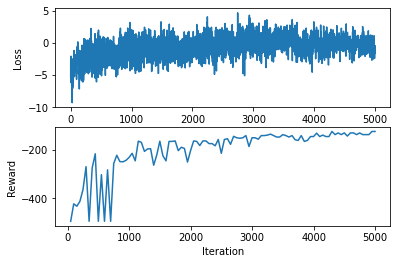

Episode reward after training: -125.0


In [ ]:
#reset environment seed
environmentSeed = 77759564327
train(5000, 10, timeAgent, timeEnvironment)

In [ ]:
stressActor = actor_distribution_network.ActorDistributionNetwork(
    stressEnvironment.observation_spec(),
    stressEnvironment.action_spec(),
    fc_layer_params=(81, 27, 9,)
    )

stressAgent = reinforce_agent.ReinforceAgent(
    stressEnvironment.time_step_spec(),
    stressEnvironment.action_spec(),
    actor_network=stressActor,
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    normalize_returns=True
    )

stressAgent.initialize()

Episode reward before training: -18185.184


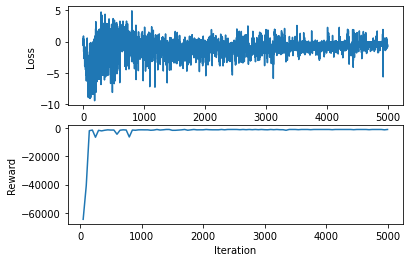

Episode reward after training: -1182.1794


In [ ]:
#reset environment seed
environmentSeed = 77759564327
train(5000, 10, stressAgent, stressEnvironment)

# Results

In [ ]:
def testPolicy(policy):
  env = EvalTimeEnv()
  env = tf_py_environment.TFPyEnvironment(env)
  print('Average time per passenger: ' + str(evaluatePolicy(env, policy, 100)))
  env = EvalStressEnv()
  env = tf_py_environment.TFPyEnvironment(env)
  print('Average stress per passenger: ' + str(evaluatePolicy(env, policy, 100)))

def testProgPolicy():
  averageTime = 0.0
  averageStress = 0.0
  for i in range(100):
    env = ElevatorSystem()
    time = 0.0
    stress = 0.0
    for i in range(50):
      env.runInterval(programmedPolicy(env))
      time += env.passengers
      stress += (env.stress - env.preStress)
    averageTime += (time/env.totalPassengers * 2)
    averageStress += stress/env.totalPassengers
  averageTime /= 100
  averageStress /= 100
  print('Average time per passenger: ' + str(averageTime))
  print('Average stress per passenger: ' + str(averageStress))

In [ ]:
randomPolicy = random_tf_policy.RandomTFPolicy(stressEnvironment.time_step_spec(), stressEnvironment.action_spec())
#test random policy
testPolicy(randomPolicy)

Average time per passenger: 45.100395
Average stress per passenger: 1533.0073


In [ ]:
#test programmed policy
testProgPolicy()

Average time per passenger: 17.191903301701966
Average stress per passenger: 63.94256188445287


In [ ]:
#test stress minimising policy
testPolicy(stressAgent.policy)

Average time per passenger: 28.040813
Average stress per passenger: 83.17442


In [ ]:
#test time minimising policy
testPolicy(timeAgent.policy)

Average time per passenger: 24.441607
Average stress per passenger: 253.86697


In [ ]:
demEnv = EvalTimeEnv()
demEnv = tf_py_environment.TFPyEnvironment(demEnv)
demonstratePolicy(demEnv,stressAgent.policy)

[[[1 0 0 0]
  [2 0 0 0]
  [3 0 0 0]
  [4 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 0 0 0]
  [4 0 0 0]
  [1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]]]
[[[1 0 0 0]
  [2 1 1 0]
  [3 0 0 0]
  [4 0 0 0]
  [2 0 0 0]
  [2 0 0 0]
  [2 0 0 0]
  [2 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 0 0 0]
  [4 0 0 0]
  [2 1 2 1]
  [2 0 0 0]
  [2 0 0 0]
  [2 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 0 0 0]
  [4 0 0 0]
  [1 1 3 1]
  [1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]]]
[[[1 0 0 0]
  [2 1 1 0]
  [3 0 0 0]
  [4 0 0 0]
  [0 1 4 1]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
[[[1 0 0 0]
  [2 1 2 0]
  [3 0 0 0]
  [4 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
[[[1 1 1 0]
  [2 1 3 0]
  [3 0 0 0]
  [4 0 0 0]
  [1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]]]
[[[1 0 0 0]
  [2 1 4 0]
  [3 0 0 0]
  [4 0 0 0]
  [1 1 2 1]
  [1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]]]
[[[1 0 0 0]
  [2 2 5 0]
  [3 0 0 0]
  [4 0 0 0]
  [0 1 3 1]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
[[[1 0 0 0]
  [2 2 6

In [ ]:
demonstratePolicy(demEnv,timeAgent.policy)

[[[1 0 0 0]
  [2 0 0 0]
  [3 0 0 0]
  [4 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 1 1 0]
  [4 0 0 0]
  [1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]
  [1 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 1 2 0]
  [4 0 0 0]
  [2 0 0 0]
  [2 0 0 0]
  [2 0 0 0]
  [2 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 1 3 0]
  [4 1 1 0]
  [3 0 0 0]
  [3 0 0 0]
  [3 0 0 0]
  [3 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 1 4 0]
  [4 1 2 0]
  [4 0 0 0]
  [4 0 0 0]
  [4 0 0 0]
  [4 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 1 5 0]
  [4 0 0 0]
  [4 1 3 1]
  [4 0 0 0]
  [4 0 0 0]
  [4 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 1 6 0]
  [4 0 0 0]
  [4 1 4 2]
  [4 0 0 0]
  [4 0 0 0]
  [4 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 1 7 0]
  [4 0 0 0]
  [3 1 5 2]
  [3 0 0 0]
  [3 0 0 0]
  [3 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 0 0 0]
  [4 0 0 0]
  [3 1 6 3]
  [3 1 8 1]
  [3 0 0 0]
  [3 0 0 0]]]
[[[1 0 0 0]
  [2 0 0 0]
  [3 1 1 0]
  [4 0 0 0]
  [2 1 7 3]
  [2 1 9 1]
  [2 0 0 0]
  [2 0 0 0]]]
[[[ 1  0  0  0]
  [ 